# Reproducing Experiment 1

For each of the nine weather contexts, we obtained the number of participants who gave each of the weather state ratings. By performing add-one Laplace smoothing on the counts, we computed a smoothed prior distribution over weather states given each context, namely $P(s)$ (Figure 3). 

In [1]:
import numpy as np
import pandas as pd
df = pd.read_csv("data/priors/long.csv")

In [2]:
df.sort_values(by=["imageID"])[:10] #just so we can see the data organized

,workerID,gender,age,income,language,order,imageID,imageCategory,stateRating,sad,disgusted,angry,neutral,content,happy,excited
102,13,F,45,0,English,4,1,amazing,4,0.21,0.04,0.04,0.42,0.81,0.68,0.52
337,39,F,45,4,English,5,1,amazing,5,0.04,0.06,0.05,0.42,0.42,0.82,0.76
149,18,M,25,6,English,6,1,amazing,5,0.02,0.20,0.14,0.14,0.75,0.83,0.69
221,26,F,65,4,English,6,1,amazing,4,0.01,0.02,0.01,0.53,0.98,0.86,0.80
251,29,F,25,4,English,9,1,amazing,5,0.29,0.06,0.06,0.60,0.74,0.84,0.47
40,5,M,35,4,English,5,1,amazing,5,0.00,0.00,0.01,0.52,1.00,1.00,0.88
136,17,M,35,4,English,2,1,amazing,5,0.02,0.01,0.02,0.17,0.91,0.97,0.97
134,16,F,45,8,English,9,1,amazing,5,0.00,0.00,0.00,0.42,0.73,0.86,0.48
350,40,M,65,4,english,9,1,amazing,4,0.02,0.02,0.01,0.10,0.93,0.78,0.60
47,7,M,35,4,English,3,1,amazing,4,0.30,0.14,0.29,0.39,0.51,0.54,0.53


In [3]:
groups = df[["imageID", "imageCategory", "stateRating"]].groupby('imageID')

value_counts = groups["stateRating"].value_counts()

counts = np.ones((9,5))
for val, cnt in value_counts.iteritems():
    img_id,state = val[0]-1,val[1]-1
    counts[img_id][state] = cnt + 1
    

priors = counts / counts.sum(axis=1,keepdims=True)  #normalize across rows
counts


array([[  1.,   1.,   1.,   9.,  42.],
       [  1.,   1.,   1.,   4.,  47.],
       [  1.,   1.,   1.,   3.,  48.],
       [  1.,   8.,  28.,  15.,   2.],
       [  1.,   1.,  12.,  34.,   6.],
       [  1.,   1.,  10.,  32.,  10.],
       [ 30.,  19.,   3.,   1.,   1.],
       [  5.,  22.,  18.,   8.,   1.],
       [ 30.,  19.,   3.,   1.,   1.]])

### Recreate figure 3

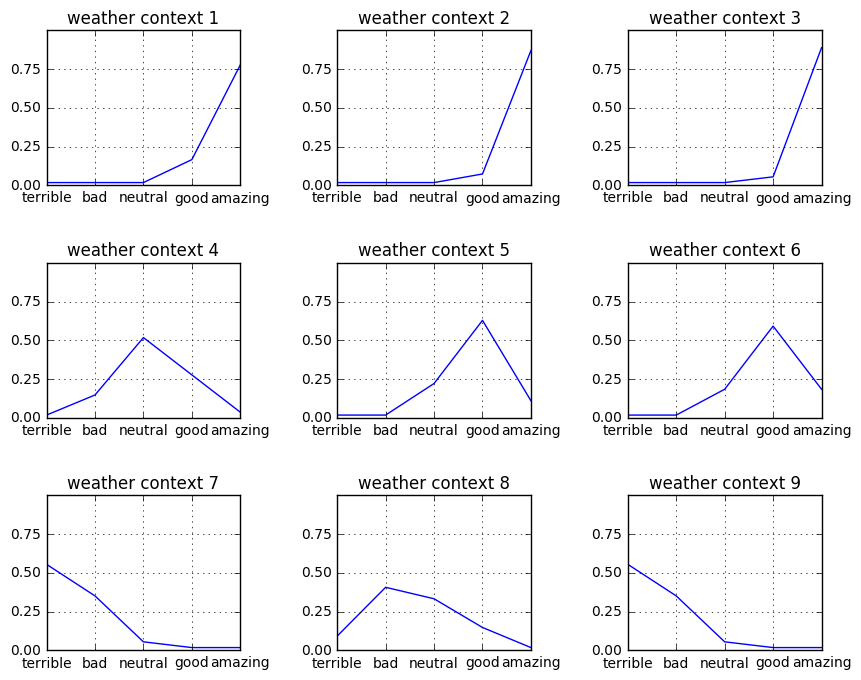

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
labels = ["terrible", "bad", "neutral", "good", "amazing"]
x = np.arange(5)

for index, row in enumerate(priors,1):
    ax1 = fig.add_subplot(33*10+index)
    ax1.set_title("weather context %i"%(index))
    ax1.set_ylim(0, 1)
    ax1.plot(x,row.tolist())
    plt.grid()
    plt.xticks(x, labels) 
    plt.yticks(np.arange(0.0, 1.0, 0.25))
    

fig.subplots_adjust(hspace=.5, wspace=.5)
plt.show()

## PCA
To examine participants’ ratings of the affect associated. with each context, we first performed Principal Component Analysis (PCA) on the seven emotion category ratings. This allowed us to compress the ratings onto a lower-dimensional space and reveal the main affective dimensions that are important in this domain, as is often done in affective science (Russell, 1980).

In [5]:
def pca(m, k):
    from numpy.linalg import svd
    from numpy.linalg import eig
    from numpy.linalg import det
    u,s,v = svd(m)
    rs = np.sqrt(np.diag(s[:k]))
    x=np.dot(u[:,:k], rs)
    y=np.dot(rs, v[:k])
    mhat=np.dot(x, y)
    return s, x, y, mhat

In [27]:
from scipy import stats
affect = df[["imageID", "sad", "disgusted", "angry", "neutral", "content", "happy", "excited"]]
std_affect = stats.zscore(affect, axis=0)
s,affect_observ,affect_components,mhat = pca(std_affect,2)

0.10909765140802624

We found that the first two principal components corresponded to the dimensions of emotional valence and emotional arousal, accounting for 69.14% and 13.86% of the variance in the data, respectively. The PCA represents emotion ratings for each trial as real values between negative and positive infinity on each of the dimensions.

## Zero Mean + STD Var
To map these values onto probability space, we first standardized the scores on each dimension to have zero mean and unit variance. 

In [30]:
affect_observ = stats.zscore(affect_observ,axis=0) #this may not be necessary as the values outputted by PCA remain standardized
affect = affect.assign(pc1 = affect_observ[:,0], pc2 = affect_observ[:,1])

-6.042030065987246e-18

## CDF to (0,1)
We then used the cumulative distribution function to convert the standardized scores into values between 0 and 1. This gives us the probabilities of Ann feeling positive (vs. negative) valence and high (vs. low) arousal for each trial, which is a two-dimensional probabilistic representation of her affect.

In [77]:
def cdf(data):
    n = len(data)
    sorted_indices = np.argsort(data) # sort your data
    x = np.array(data)[sorted_indices]
    y = np.arange(1, n + 1) / n # calculate cumulative probability
    return x, y, sorted_indices

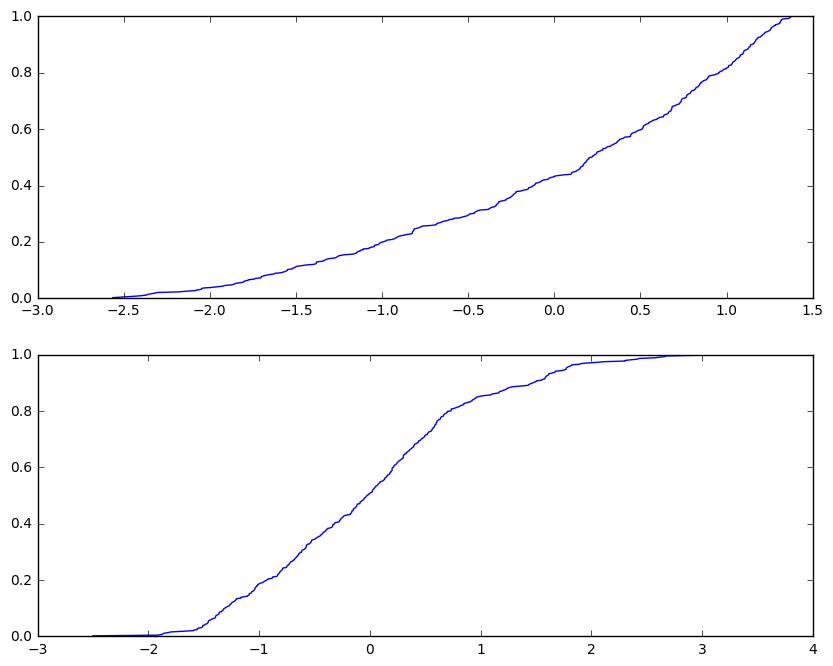

In [86]:
x0,y0,indices0 = cdf(affect_observ[:,0])
x1,y1,indices1 = cdf(affect_observ[:,1])

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
ax1.plot(x0,y0)
ax2 = fig.add_subplot(212)
ax2.plot(x1,y1)

plt.show()

the plots above give us "the probability of ann feeling positive valence & high arousal for each trial". Let's try a single trial and see what we get


In [106]:
ids = np.array(df["imageID"])[indices0]

d = {'imageID': ids, 'probability': y0}
df = pd.DataFrame(data=d)
df.groupby('imageID').mean()

,probability
imageID,
1,0.544542
2,0.540608
3,0.553057
4,0.494701
5,0.437225
6,0.469110
7,0.473506
8,0.520987
9,0.476468


It is not clear which principal component is valence and which one is arousal
nor do these values make much sense for "terrible".

, but given that they later project them into a binary space, they probably take the intervals from -INF to 0 in order to get the probability of negative valence/arousal and vice versa for positive valence/arousal

## Avg Probability for each state (across rows for each column)
By calculating the average probabilities of positive valence and high arousal given each weather state rating, we obtain the probability of positive valence and high arousal associated with each weather state, namely $P(A|s)$ (Figure 4).

so i imagine that here we group the rows by image and then find the avg probability

In [81]:
affect

,imageID,sad,disgusted,angry,neutral,content,happy,excited,pc1,pc2
0,5,0.29,0.12,0.00,0.46,0.73,0.74,0.36,0.730159,0.584583
1,6,0.10,0.31,0.02,0.83,0.77,0.63,0.33,0.730159,1.781063
2,3,0.01,0.00,0.00,0.09,0.49,0.84,0.84,0.730159,-0.972938
3,7,0.48,0.74,0.36,0.65,0.09,0.29,0.62,0.730159,0.367226
4,9,0.49,0.62,0.64,0.74,0.45,0.53,0.16,0.730159,0.939458
5,4,0.51,0.10,0.19,0.69,0.61,0.61,0.21,0.730159,1.233786
6,2,0.00,0.00,0.69,0.41,0.00,0.64,0.43,0.730159,-0.117300
7,1,0.00,0.00,0.02,0.25,0.62,0.81,0.57,0.730159,-0.314826
8,8,0.37,0.29,0.20,0.53,0.54,0.14,0.27,0.730159,0.959738
9,7,0.55,0.27,0.75,0.31,0.04,0.05,0.25,0.730159,-0.237137


In [ ]:
# I accidently confused affect with state when trying to calculate priors. 
# However this code is pretty neat so I'm going to keep it in case I need it later
# groups = df[["imageID", "sad", "disgusted", "angry", "neutral", "content", "happy", "excited"]].groupby('imageID')
# groups = groups.sum()
# priors = groups.div(groups.sum(axis=1), axis=0) #normalize across rows
# priors

